## Vertical profiles of the heating rates due to different processes as area mean and time mean for 80 km resolution

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing utility dictionaries
import sys
sys.path.append('/pf/b/b381185/behrooz/Hackathon_b/nawdex-hackathon/shared')

# simulations dictionary
import dict_nawdexsims
simdict = dict_nawdexsims.simdictionary()

# dictionary for the days to be analyzed
anadaysdict = dict_nawdexsims.anadaysdictionary()

# dictionary for colors
colordict = dict_nawdexsims.colordictionary()

## deriving height at full levels

In [3]:
def get_fulllevel_height():
    # define simulation
    resolution = '80km'
    sim = '0001'
    expid = 'nawdexnwp-' + resolution + '-mis-' + sim
    # read ocean mask
    ipath_oceanmask = '/work/bb1018/nawdex-hackathon_pp/'
    da_ocean = xr.open_dataset(ipath_oceanmask + '/openoceanmask/' + expid + \
                               '_openoceanmask.nc')['mask_openocean']
    index = np.where(da_ocean == 1)[0]
    del da_ocean, ipath_oceanmask
    # read z_ifc data
    ipath = '/work/bb1018/b380459/NAWDEX/ICON_OUTPUT_NWP/' + \
            'nawdexnwp-' + resolution + '-mis-' + sim + '/'
    ds = xr.open_dataset(ipath + 'nawdexnwp-' + resolution + '-mis-' + \
                         sim + '_2016092200_fg_DOM01_ML_0036.nc')
    del ipath
    # apply ocean mask on z_ifc to make sure to look at ocean grid point
    ds = ds.isel(ncells=index)
    # calculate full levels based on z_ifc
    z_full = (ds.z_ifc[:,0] - (ds.z_ifc[:,0].diff('height_3')/2)).values
    #print(z_full)
    del resolution, sim, expid, index, ds
    return z_full

zfull = get_fulllevel_height()

## Load domain mean_ocean mask datasets 

sim_set_1 = radiative heating rates

sim_set_2 = temperature tendencies

In [4]:
sim_set_1 = []

for sim in list(simdict.keys()):
    
    path = '/work/bb1018/nawdex-hackathon_pp/radiative_heating_domain_mean/'
        
    ds = xr.open_dataset(path+'atmradheating_fldmean_openocean_'+sim+'.nc')
    
    # deriving cloud sw, lw and net radiative heating rates
    ds['lw_crh'] = ds['ddt_temp_radlw_fromflux'] - ds['ddt_temp_radlwclr_fromflux']
    ds['sw_crh'] = ds['ddt_temp_radsw_fromflux'] - ds['ddt_temp_radswclr_fromflux']
    ds['nt_crh'] = ds['lw_crh'] + ds['sw_crh']
        
    ds.attrs['simulation'] = sim    
     
    # Only the selected days 
    startday  = simdict[sim]['start']
    anadays = anadaysdict[startday]

    ds = ds.sel(time=slice(anadays[0], anadays[-1]))    
    sim_set_1.append(ds)
    
    del sim   

In [5]:
sim_set_2 = []

for sim in list(simdict.keys()):
    
    path = '/work/bb1018/nawdex-hackathon_pp/temp_tendencies_domain_mean/'
        
    ds = xr.open_dataset(path+'3d_ddtemp_'+sim+'.nc')
    
    # net radiation temp_tendency
    ds['ddt_temp_rad'] = ds['ddt_temp_radlw'] + ds['ddt_temp_radsw']
        
    ds.attrs['simulation'] = sim
     
    # Only the selected days 
    startday  = simdict[sim]['start']
    anadays = anadaysdict[startday]

    ds = ds.sel(time=slice(anadays[0], anadays[-1]))    
    sim_set_2.append(ds)
    
    del sim

## Merge datasets for climatology average with regard to their resolution, convection and microphysics shcemes

In [6]:
def time_merge_list(sim_set,resolution):
    
    # empty list for diffrent setups
    ds_merge1 = []
    ds_merge2 = []
    ds_merge3 = []
    ds_merge4 = []
    ds_merge5 = []
    ds_merge6 = []
       
    for i in range(len(sim_set)):
        
        conv = simdict[sim_set[i].attrs['simulation']]['conv']
        mphys = simdict[sim_set[i].attrs['simulation']]['mphys']
        res = simdict[sim_set[i].attrs['simulation']]['res']
        
        if conv == 1 and mphys ==1 and res==resolution:
            
            ds_merge1.append(sim_set[i])
            ds1 = xr.concat(ds_merge1,dim='time')
            
        elif conv == 1 and mphys ==2 and res==resolution:
            
            ds_merge2.append(sim_set[i])
            ds2 = xr.concat(ds_merge2,dim='time')
            
        elif conv == 0 and mphys ==1 and res==resolution:
            
            ds_merge3.append(sim_set[i])
            ds3 = xr.concat(ds_merge3,dim='time')
         
        elif conv == 0 and mphys ==2 and res==resolution:
            
            ds_merge4.append(sim_set[i])
            ds4 = xr.concat(ds_merge4,dim='time')
            
        elif conv == 2 and mphys ==1 and res==resolution:
            
            ds_merge5.append(sim_set[i])
            ds5 = xr.concat(ds_merge5,dim='time')
            
        elif conv == 2 and mphys ==2 and res==resolution:
            
            ds_merge6.append(sim_set[i])
            ds6 = xr.concat(ds_merge6,dim='time')
            
    if resolution=='80km' or resolution=='40km' or resolution=='20km' or resolution=='10km' or resolution=='5km':
        
        return (ds1,ds2) # Only with convection on / 1 and 2 moment mphy
    
    else:
        
        return (ds3,ds4,ds5,ds6) #( for 2km resolution with conv:off/only shallow convection, 1 and 2 moment mphy)

## select datasets for 80 Km resolution 

In [7]:
# resolution: 80 km averaged over 14 days of simulations

crh_80_clim = time_merge_list(sim_set_1,'80km')
ddt_80_clim = time_merge_list(sim_set_2,'80km')

# adding them together
crh_ddt_80km = crh_80_clim + ddt_80_clim

## Plot vertical profiles of heating rates

In [8]:
# function for vertical profile plot

def plot_varmean(_ds_list, _var, fs):
    
    fig.tight_layout(pad=2.5)
    
    # empty lists for time average
    
    elist1 = []
    elist2 = []
    
    for ds in _ds_list:

        # make sure that _var is part of dataset
        if _var not in ds.keys():
            continue

            
        mphys = simdict[ds.attrs['simulation']]['mphys']
        
        if mphys==1:
            
            elist1.append(ds[_var].sel(height=slice(16,50)).mean('time').values)
        
        elif mphys==2:
            
            elist2.append(ds[_var].sel(height=slice(16,50)).mean('time').values)    

            
    ax = fig.add_subplot(1,2,1)
    
    # time average over 14 days
    line1 = np.mean(elist1,axis=0)
    
    if _var == 'lw_crh':
        plt.plot(line1*86400,zfull[15:50]/1e3,linewidth=2,label='lw_crh',color=colordict['80km'])
    if _var == 'sw_crh':
        plt.plot(line1*86400,zfull[15:50]/1e3,linewidth=2,label='sw_crh',color=colordict['80km'],linestyle='--')    
    if _var == 'ddt_temp_radlw':
        plt.plot(line1*86400,zfull[15:50]/1e3,linewidth=2,label='lw_rad',color=colordict['40km'])
    if _var == 'ddt_temp_radsw':
        plt.plot(line1*86400,zfull[15:50]/1e3,linewidth=2,label='sw_rad',color=colordict['40km'],linestyle='--')    
    if _var == 'ddt_temp_dyn2':
        plt.plot(line1*86400,zfull[15:50]/1e3,linewidth=2,label='dyn',color=colordict['20km'])
    if _var == 'ddt_temp_turb':
        plt.plot(line1*86400,zfull[15:50]/1e3,linewidth=2,label='turb',color=colordict['10km'])
    if _var == 'ddt_temp_pconv':
        plt.plot(line1*86400,zfull[15:50]/1e3,linewidth=2,label='conv',color=colordict['5km'])
    if _var == 'ddt_temp_mphy':
        plt.plot(line1*86400,zfull[15:50]/1e3,linewidth=2,label='mphy',color=colordict['2km'])    
        
    plt.tick_params(labelsize=13)
    #plt.ylabel("Height (km)",fontsize=12)
            
    ax.spines['left'].set_bounds(5,15)
    ax.spines['bottom'].set_bounds(-2.5,2.5)#(-0.25,0.25)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
    plt.xlim(-2.5,2.5)#(-0.25,0.25)
    plt.ylim(5,15)
    ax.yaxis.set_ticks([5,7,9,11,13,15])
    ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=fs)#,fontweight='bold')
    ax.xaxis.set_ticks([-2,-1,0,1,2])
    ax.xaxis.set_ticklabels([-2.0,-1.0,0.0,1.0,2.0], fontsize=fs)#,fontweight='bold')
                
    plt.title('Microphysics: One-moment scheme',fontsize=fs, pad=20)
    plt.xlabel('Heating rates (K/day)',fontsize=fs)
    plt.legend(fontsize=fs-3)
    plt.ylabel("Height (km)",fontsize=fs)
    
    
    # mphy = 2
            
    ax = fig.add_subplot(1,2,2)
    
    # time average over 14 days
    line2 = np.mean(elist2,axis=0)
    
    if _var == 'lw_crh':
        plt.plot(line2*86400,zfull[15:50]/1e3,linewidth=2,label='lw_crh',color=colordict['80km'])
    if _var == 'sw_crh':
        plt.plot(line2*86400,zfull[15:50]/1e3,linewidth=2,label='sw_crh',color=colordict['80km'],linestyle='--')    
    if _var == 'ddt_temp_radlw':
        plt.plot(line2*86400,zfull[15:50]/1e3,linewidth=2,label='lw_rad',color=colordict['40km'])
    if _var == 'ddt_temp_radsw':
        plt.plot(line2*86400,zfull[15:50]/1e3,linewidth=2,label='sw_rad',color=colordict['40km'],linestyle='--')    
    if _var == 'ddt_temp_dyn2':
        plt.plot(line2*86400,zfull[15:50]/1e3,linewidth=2,label='dyn',color=colordict['20km'])
    if _var == 'ddt_temp_turb':
        plt.plot(line2*86400,zfull[15:50]/1e3,linewidth=2,label='turb',color=colordict['10km'])
    if _var == 'ddt_temp_pconv':
        plt.plot(line2*86400,zfull[15:50]/1e3,linewidth=2,label='conv',color=colordict['5km'])
    if _var == 'ddt_temp_mphy':
        plt.plot(line2*86400,zfull[15:50]/1e3,linewidth=2,label='mphy',color=colordict['2km']) 
        
    plt.tick_params(labelsize=13)
    #plt.ylabel("Height (km)",fontsize=12)
            
    ax.spines['left'].set_bounds(5,15)
    ax.spines['bottom'].set_bounds(-2.5,2.5)#(-0.25,0.25)
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
    plt.xlim(-2.5,2.5)#(-0.25,0.25)
    plt.ylim(5,15)
    ax.yaxis.set_ticks([5,7,9,11,13,15])
    ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=fs)#,fontweight='bold')
    ax.xaxis.set_ticks([-2,-1,0,1,2])
    ax.xaxis.set_ticklabels([-2.0,-1.0,0.0,1.0,2.0], fontsize=fs)#,fontweight='bold')
                
    plt.title('Microphysics: Two-moment scheme',fontsize=fs, pad=20)
    plt.xlabel('Heating rates (K/day)',fontsize=fs)


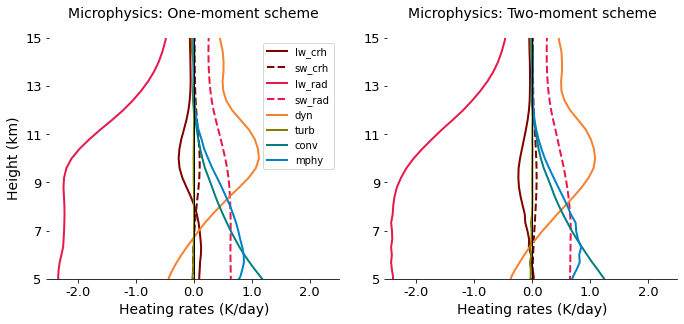

In [9]:
# plot_ resolution: 80 km averaged over 14 days of simulations

fig=plt.figure(figsize=(10,5)) 
#ax = fig

for var in ['lw_crh','sw_crh','ddt_temp_radlw','ddt_temp_radsw'
            ,'ddt_temp_dyn2','ddt_temp_turb','ddt_temp_pconv','ddt_temp_mphy']:
     
    plot_varmean(crh_ddt_80km, var)
    
    #plt.savefig('clim_hr_80', bbox_inches = 'tight', dpi=600)

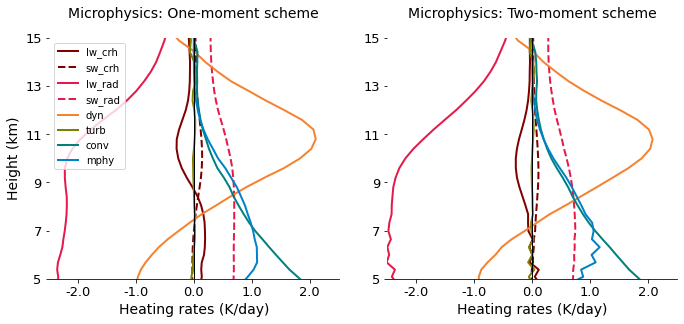

In [13]:
# resolution: 80 km averaged over for 1 period of simulation, 22092016

crh_ddt_80km_22 = [sim_set_1[0], sim_set_1[1] , sim_set_2[0] , sim_set_2[1]]

fig=plt.figure(figsize=(10,5)) 
ax = fig

for var in ['lw_crh','sw_crh','ddt_temp_radlw','ddt_temp_radsw'
            ,'ddt_temp_dyn2','ddt_temp_turb','ddt_temp_pconv','ddt_temp_mphy']:
     
    plot_varmean(crh_ddt_80km_22, var)
    
    #plt.savefig('clim_hr', bbox_inches = 'tight', dpi=600)

## Impact of resolution on clear sky radiative heating

In [14]:
list_climatology = []

for res in ['80km','40km','20km','10km','5km','2km']:
    
    list_climatology.append(time_merge_list(sim_set_1,res))
    
# change from tuple to list

c_list = list_climatology[0]+list_climatology[1]+list_climatology[2]+list_climatology[3]+list_climatology[4]+list_climatology[5]   

icon_list = list(c_list) 

In [106]:
# function for plotting vertical profiles

# ** for ERA5
# choise of height or level selection is based on 
# https://www.ecmwf.int/en/forecasts/documentation-and-support/137-model-levels:
# where index 64 is appro. 15 Km and index 98 is approximaetly 5 Km

def plot_thmean(_ds_icon_list, _var,num):
    
    ax = fig.add_subplot(2,4,num)
    fig.tight_layout(pad=2.5)
    
    for ds in _ds_icon_list:
        # make sure that _var is part of dataset
        if _var not in ds.keys():
            continue
        
        # Options for ERA5 CRH 
        if ds.attrs['simulation'] == 'ERA5_sep_1':
            
            pcolor = 'k'
            conv = 1
            mphys = 1 
        
        elif ds.attrs['simulation'] == 'ERA5_oct_1':
            
            pcolor = 'k'
            conv = 1
            mphys = 1
         
        elif ds.attrs['simulation'] == 'ERA5_sep_2':
            
            pcolor = 'k'
            conv = 1
            mphys = 2 
        
        elif ds.attrs['simulation'] == 'ERA5_oct_2':
            
            pcolor = 'k'
            conv = 1
            mphys = 2
        
        # options for CloudSat data
        elif ds.attrs['simulation'] == 'CC_1':
            
            pcolor = 'k'
            conv = 1
            mphys = 1
            
        elif ds.attrs['simulation'] == 'CC_2':
            
            pcolor = 'k'
            conv = 1
            mphys = 2    
            
        # ICON_simulations
        else:
            
            # get plotting color according to ICON resolution

            pcolor=colordict[simdict[ds.attrs['simulation']]['res']]
            # get linestyle according to convection scheme
            conv = simdict[ds.attrs['simulation']]['conv']
            if conv==0:
                lstyle='--'
            elif conv==1:
                lstyle='-'
            elif conv==2:
                lstyle=':'

            mphys = simdict[ds.attrs['simulation']]['mphys']
            
            
        if mphys==1:
            
            ax = fig.add_subplot(2,4,num)
            
            # ERA5 plot
            if ds.attrs['simulation'] == 'ERA5_sep_1':
                
                plt.plot(ds[_var].sel(lev=slice(64,99)).values[::-1]*86400,height,
                     color='k',linewidth=2,linestyle='dashed',label='ERA5_Sep')
            
            elif ds.attrs['simulation'] == 'ERA5_oct_1':
                
                plt.plot(ds[_var].sel(lev=slice(64,99)).values[::-1]*86400,height,
                     color='k',linewidth=2,linestyle='dotted',label='ERA5_Oct')
                
            # CloudSat/Calipso
            elif ds.attrs['simulation'] == 'CC_1':
                
                plt.plot(ds[_var].isel(lev=slice(41,83)).values,height_cc,
                     color='k',linewidth=2,linestyle='solid',label='CloudSat/Calipso')
            
            # ICON_sims plots
            else:
                
            # average over 14 days_Climatology
                
                line = ds[_var].sel(height=slice(16,50)).mean('time')
                #dailymean = ds[_var].sel(height=slice(16,50)).groupby('time.day').mean('time')
                #std_height = np.std(dailymean,axis=0)
                #ste_height = std_height/np.sqrt(np.size(dailymean['day']))

                plt.plot(line.values*86400,zfull[15:50]/1e3,color=pcolor,linestyle=lstyle,
                         linewidth=2,label=simdict[ds.attrs['simulation']]['res'])
                
                #if simdict[ds.attrs["simulation"]]["res"]=="80km":
                #    plt.fill_betweenx(y = zfull[15:50]/1e3, x1=(line-std_height)*86400,
                #                      x2=(line+std_height)*86400, color = pcolor, alpha=0.2) 
                #    plt.fill_betweenx(y = zfull[15:50]/1e3, x1=(line-ste_height)*86400,
                #                      x2=(line+ste_height)*86400, color = pcolor, alpha=0.3)
                
            
            plt.tick_params(labelsize=13)
            #plt.ylabel("Height (km)",fontsize=12)
            
            if num == 1:
                
                ax.spines['left'].set_bounds(5,15)
                #ax.spines['bottom'].set_bounds(-0.3,0.3)#(-0.25,0.25)
                ax.spines['top'].set_color('none')
                ax.spines['right'].set_color('none')
                ax.spines['left'].set_color('none')
                #ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
                #plt.xlim(-0.3,0.3)#(-0.25,0.25)
                plt.ylim(5,15)
                
                plt.title('Microphysics: One-moment scheme',fontsize=15, pad=20)
                plt.xlabel('radswclr heating rate (K/day)',fontsize=14)
                plt.legend(fontsize=12)
                plt.ylabel("Height (km)",fontsize=14)
                ax.yaxis.set_ticks([5,7,9,11,13,15])
                ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=13)#,fontweight='bold')
                #ax.xaxis.set_ticks([-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3])
                #ax.xaxis.set_ticklabels([-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3], fontsize=13)#,fontweight='bold')
                
            if num == 2:
                
                ax.spines['left'].set_bounds(5,15)
                #ax.spines['bottom'].set_bounds(-0.5,0.5)
                ax.spines['top'].set_color('none')
                ax.spines['right'].set_color('none')
                ax.spines['left'].set_color('none')
                plt.xlabel('radlwclr heating rate (K/day)',fontsize=14)
                #ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
                #plt.xlim(-0.5,0.5)
                plt.ylim(5,15)
                ax.yaxis.set_ticks([5,7,9,11,13,15])
                ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=13)#,fontweight='bold')
                #ax.xaxis.set_ticks([-0.5,-0.25,0.0,0.25,0.5])
                #ax.xaxis.set_ticklabels([-0.5,-0.25,0.0,0.25,0.5], fontsize=13)#,fontweight='bold')
                
            if num == 3:
                
                ax.spines['left'].set_bounds(5,15)
                #ax.spines['bottom'].set_bounds(-0.5,0.5)
                ax.spines['top'].set_color('none')
                ax.spines['right'].set_color('none')
                ax.spines['left'].set_color('none')
                plt.xlabel('radsw heating rate (K/day)',fontsize=14)
                #ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
                #plt.xlim(-0.5,0.5)
                plt.ylim(5,15)
                ax.yaxis.set_ticks([5,7,9,11,13,15])
                ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=14)#,fontweight='bold')
                #ax.xaxis.set_ticks([-0.5,-0.25,0.0,0.25,0.5])
                #ax.xaxis.set_ticklabels([-0.5,-0.25,0.0,0.25,0.5], fontsize=13)#,fontweight='bold')
                
            if num == 4:
                
                ax.spines['left'].set_bounds(5,15)
                #ax.spines['bottom'].set_bounds(-0.5,0.5)
                ax.spines['top'].set_color('none')
                ax.spines['right'].set_color('none')
                ax.spines['left'].set_color('none')
                plt.xlabel('radlw heating rate (K/day)',fontsize=14)
                #ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
                #plt.xlim(-0.5,0.5)
                plt.ylim(5,15)
                ax.yaxis.set_ticks([5,7,9,11,13,15])
                ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=14)#,fontweight='bold')
                #ax.xaxis.set_ticks([-0.5,-0.25,0.0,0.25,0.5])
                #ax.xaxis.set_ticklabels([-0.5,-0.25,0.0,0.25,0.5], fontsize=13)#,fontweight='bold')    
        
            
        elif mphys==2:
            
            ax = fig.add_subplot(2,4,num+4)
            
            # ERA5 plot
            if ds.attrs['simulation'] == 'ERA5_sep_2':
                
                plt.plot(ds[_var].sel(lev=slice(64,99)).values[::-1]*86400,height,
                     color='k',linewidth=2,linestyle='dashed',label='ERA5_Sep')
            
            elif ds.attrs['simulation'] == 'ERA5_oct_2':
                
                plt.plot(ds[_var].sel(lev=slice(64,99)).values[::-1]*86400,height,
                     color='k',linewidth=2,linestyle='dotted',label='ERA5_Oct')
                
            # CloudSat/Calipso
            elif ds.attrs['simulation'] == 'CC_2':
                
                plt.plot(ds[_var].isel(lev=slice(41,83)).values,height_cc,
                     color='k',linewidth=2,linestyle='solid',label='CloudSat/Calipso')    
            
            # ICON_sims plots
            else:
                
            # average over 14 days_Climatology
                
                line = ds[_var].sel(height=slice(16,50)).mean('time')
                #dailymean = ds[_var].sel(height=slice(16,50)).groupby('time.day').mean('time')
                #std_height = np.std(dailymean,axis=0)
                #ste_height = std_height/np.sqrt(np.size(dailymean['day']))

                plt.plot(line.values*86400,zfull[15:50]/1e3,color=pcolor,linestyle=lstyle,
                         linewidth=2,label=simdict[ds.attrs['simulation']]['res'])
                
                #if simdict[ds.attrs["simulation"]]["res"]=="80km":
                #    plt.fill_betweenx(y = zfull[15:50]/1e3, x1=(line-std_height)*86400,
                #                      x2=(line+std_height)*86400, color = pcolor, alpha=0.2) 
                #    plt.fill_betweenx(y = zfull[15:50]/1e3, x1=(line-ste_height)*86400,
                #                      x2=(line+ste_height)*86400, color = pcolor, alpha=0.3)
            
            plt.tick_params(labelsize=13)
            
            if num+4 == 5:
                
                ax.spines['left'].set_bounds(5,15)
                #ax.spines['bottom'].set_bounds(-0.3,0.3)#(-0.25,0.25)
                ax.spines['top'].set_color('none')
                ax.spines['right'].set_color('none')
                ax.spines['left'].set_color('none')
                #plt.xlim(-0.3,0.3)#(-0.25,0.25)
                
                plt.title('Microphysics: Two-moment scheme',fontsize=15, pad=20)
                plt.xlabel('radswclr heating rate (K/day)',fontsize=14)
                plt.ylabel("Height (km)",fontsize=14)
                #ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
                #plt.legend(fontsize=12)
                plt.ylim(5,15)
                ax.yaxis.set_ticks([5,7,9,11,13,15])
                ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=13)#,fontweight='bold')
                #ax.xaxis.set_ticks([-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3])
                #ax.xaxis.set_ticklabels([-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3], fontsize=13)#,fontweight='bold')
                
            if num+4 == 6:
                
                ax.spines['left'].set_bounds(5,15)
                #ax.spines['bottom'].set_bounds(-0.5,0.5)
                ax.spines['top'].set_color('none')
                ax.spines['right'].set_color('none')
                ax.spines['left'].set_color('none')
                plt.xlabel('radlwclr heating rate (K/day)',fontsize=14)
                #ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
                #plt.xlim(-0.5,0.5)
                plt.ylim(5,15)
                ax.yaxis.set_ticks([5,7,9,11,13,15])
                ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=13)#,fontweight='bold')
                #ax.xaxis.set_ticks([-0.5,-0.25,0.0,0.25,0.5])
                #ax.xaxis.set_ticklabels([-0.5,-0.25,0.0,0.25,0.5], fontsize=13)#,fontweight='bold')
                
            if num+4 == 7:
                
                ax.spines['left'].set_bounds(5,15)
                #ax.spines['bottom'].set_bounds(-0.5,0.5)
                ax.spines['top'].set_color('none')
                ax.spines['right'].set_color('none')
                ax.spines['left'].set_color('none')
                plt.xlabel('radsw heating rate (K/day)',fontsize=14)#,fontweight='bold')
                #ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
                #plt.xlim(-0.5,0.5)
                plt.ylim(5,15)
                ax.yaxis.set_ticks([5,7,9,11,13,15])
                ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=13)#,fontweight='bold')
                #ax.xaxis.set_ticks([-0.5,-0.25,0.0,0.25,0.5])
                #ax.xaxis.set_ticklabels([-0.5,-0.25,0.0,0.25,0.5], fontsize=13)#,fontweight='bold')
                
                
            if num+4 == 8:
                
                ax.spines['left'].set_bounds(5,15)
                #ax.spines['bottom'].set_bounds(-0.5,0.5)
                ax.spines['top'].set_color('none')
                ax.spines['right'].set_color('none')
                ax.spines['left'].set_color('none')
                plt.xlabel('radlw heating rate (K/day)',fontsize=14)#,fontweight='bold')
                #ax.axvline(x=0, ymin=0.0, ymax=1,c='black', lw=1)
                #plt.xlim(-0.5,0.5)
                plt.ylim(5,15)
                ax.yaxis.set_ticks([5,7,9,11,13,15])
                ax.yaxis.set_ticklabels([5,7,9,11,13,15], fontsize=13)#,fontweight='bold')
                #ax.xaxis.set_ticks([-0.5,-0.25,0.0,0.25,0.5])
                #ax.xaxis.set_ticklabels([-0.5,-0.25,0.0,0.25,0.5], fontsize=13)#,fontweight='bold')    
            

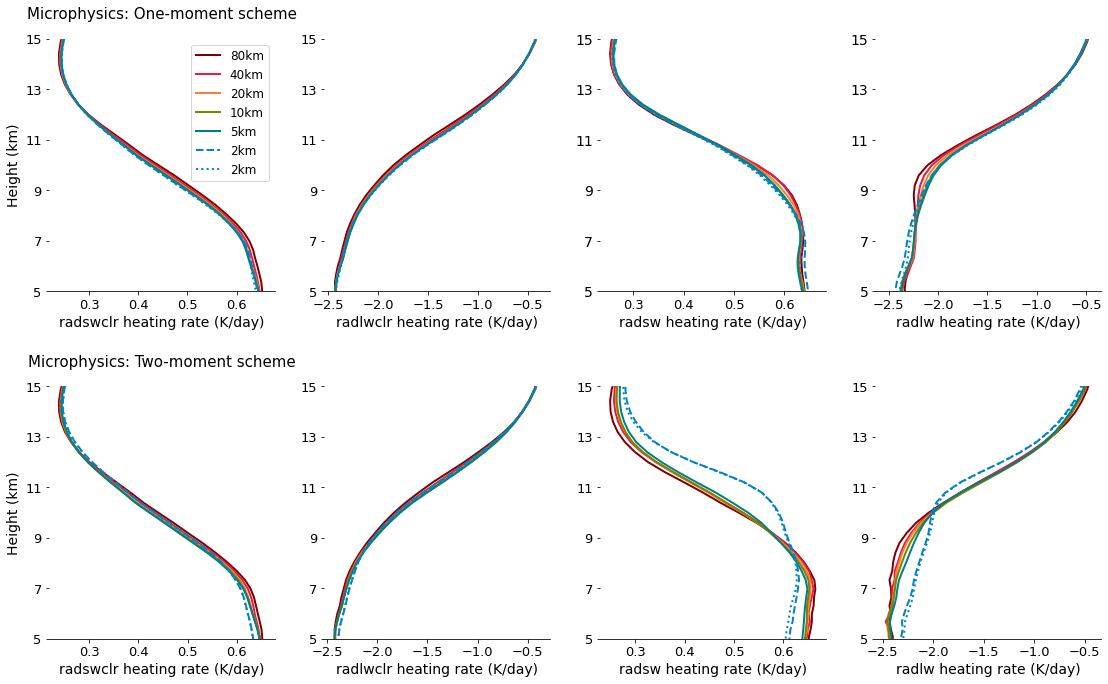

In [108]:
# vertical profiles of ICON cloud-rad heating rates: all resolution and different microphysics

i = 0

fig=plt.figure(figsize=(16,10)) #18,12
ax = fig

for var in ['ddt_temp_radswclr_fromflux','ddt_temp_radlwclr_fromflux','ddt_temp_radsw_fromflux','ddt_temp_radlw_fromflux']:
    
    i = i + 1
    
    plot_thmean(icon_list, var,i)
    
    plt.savefig('clim_rh', bbox_inches = 'tight', dpi=300)